## Global variables go here

In [4]:
import os
import tensorflow as tf

# --- CONFIGURATION ---
# This path points to the root 'sequences' folder containing all the video folders.
DATASET_ROOT = '/kaggle/input/vimeo-triplet/vimeo_triplet/sequences'

# The size to which all input images will be resized.
IMAGE_SIZE = (256, 256)
KERNEL_SIZE = 9
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE # For optimal performance on Kaggle GPU

## Paths to target images

Have already saved the list of triplet paths in triplets.pkl

In [5]:
import pickle


with open("/kaggle/input/vimeo-triplets-paths/triplets.pkl", "rb") as f:
    triplets = pickle.load(f)

In [6]:
import random
random.shuffle(triplets)

# Compute split index (90% train, 10% test)
split_idx = int(0.9 * len(triplets))

train_triplets = triplets[:split_idx]
test_triplets  = triplets[split_idx:]

In [7]:
import random
random.shuffle(triplets)

# Compute split index (90% train, 10% test)
split_idx = int(0.9 * len(triplets))

train_triplets = triplets[:split_idx]
test_triplets  = triplets[split_idx:]

## Image loading and processing

In [8]:
def load_image_triplet(triplet: list[str]):
    """
    Given one triplet [im1_path, im2_path, im3_path], load and preprocess them.
    Returns:
        input_tensor: (256, 256, 6) from im1+im3
        target_tensor: (256, 256, 3) from im2
    """

    im1_path, im2_path, im3_path = triplet
    
    def decode_and_preprocess(path: str):
        img = tf.io.read_file(path)                                 # Gets the raw bytes from storage, encoded in the png way

        img = tf.io.decode_png(img, channels=3)                     # - Decodes those bytes into a super matrix of RGB values for each pixel.
                                                                    # - This super matrix is called a tensor. Just like NumPy has arrays,
                                                                    # Pandas has dataframes, Python has lists, TensorFlow has tensors.
                                                                    # - for a 1080 by 1920 image (row by column), we get a tensor
                                                                    # of shape (1080, 1920, 3) (row by column by elements/channels(RGB))
                                                                    # - other possible channel options are 2 (for black/white)
                                                                    # and 4 (for RGB and alpha (transparency))

        img = tf.image.resize(img, IMAGE_SIZE, method='bicubic')    # - resizes the image to a set image size
                                                                    # - 'bicubic' means it takes the RGB values for 16 pixels in
                                                                    # a square and combines them into RGB values for just one pixel
                                                                    # - other options include 'nearest' (combine the 2 nearest pixels, leads to
                                                                    # blocky image) and 'bilinear' (average the four nearest pixels, less refined)

        img = img / 255.0                                           # - remember, each RGB value is from 0 to 255. This line divides each value by
                                                                    # 255, making the numbers range from 0 to 1 instead (normalization)
                                                                    # for instance, (127, 255, 0) becomes (0.5, 1, 0)

        return img                                                  # Now, simply return that tensor of shape (256, 256, 3)


    
    im1_tensor = decode_and_preprocess(im1_path)
    im3_tensor = decode_and_preprocess(im3_path)
    im2_tensor = decode_and_preprocess(im2_path)
    
    input_tensor = tf.concat([im1_tensor, im3_tensor], axis=-1)     # - Remember, im1_tensor has shape (256 pixel-height, 256 pixel-width, 3-channel),
                                                                    # and so does im3_tensor. .concat combines those two tensors to (256, 256, 6)

    
    # Input tensor: (256, 256, 6)
    # However, TensorFlow does not quite KNOW that, so it can't optimize workflow very well, trying to make allowance for tensors that might be bigger.
    # We have to guarantee to TensorFlow that our input_tensor and target_tensor will always be (256, 256, 3/6)
    # THEN, TensorFlow can work with assurance and surety.
    # Also, remember that IMAGE_SIZE = (256, 256), so we have to do some element picking. We can't pass a tuple as an argument to .set_shape()
    input_tensor.set_shape([IMAGE_SIZE[0], IMAGE_SIZE[1], 6])       

    # Target tensor: (256, 256, 3)
    im2_tensor.set_shape([IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
    
    return input_tensor, im2_tensor

## Tensorflow-python bridge

In [9]:
@tf.function(input_signature=[tf.TensorSpec(None, tf.string)])
def tf_load_image_triplet(triplet):
    input_tensor, target_tensor = tf.py_function(
        load_image_triplet, 
        [triplet], 
        (tf.float32, tf.float32)
    )

    # Explicitly set shapes so TensorFlow knows them
    input_tensor.set_shape([IMAGE_SIZE[0], IMAGE_SIZE[1], 6])
    target_tensor.set_shape([IMAGE_SIZE[0], IMAGE_SIZE[1], 3])

    return input_tensor, target_tensor

## Creating the TensorFlow dataset and pipeline

In [10]:
def create_tf_dataset(triplet_paths, batch_size=BATCH_SIZE):
    """
    Creates a high-performance tf.data.Dataset for training.
    """
    # Create dataset from the list of im2.png file paths
    dataset = tf.data.Dataset.from_tensor_slices(triplet_paths)

    # Shuffle paths globally before processing (crucial for large datasets)
    dataset = dataset.shuffle(buffer_size=1024)

    # Map the loading function. tf.data.experimental.map_and_batch is often faster
    # but a simple map works fine too. num_parallel_calls is key for speed.
    dataset = dataset.map(tf_load_image_triplet, num_parallel_calls=AUTOTUNE)

    # Batch the elements
    dataset = dataset.batch(batch_size, drop_remainder=True)

    # Prefetch data to the GPU memory to overlap CPU data loading and GPU training
    dataset = dataset.prefetch(AUTOTUNE)
    
    # Cache the dataset if it fits in memory (not recommended for 80K images)
    # dataset = dataset.cache() 

    return dataset

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## VFI

In [12]:
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable(package="Custom")
class SeparableKernelWarping(layers.Layer):
    """
    Custom layer for adaptive separable kernel warping in Video Frame Interpolation (VFI).

    This layer takes two input frames (I1, I3) and a set of predicted kernels,
    then applies separable convolution in two passes (horizontal and vertical)
    to synthesize the intermediate frame.
    """

    def __init__(self, kernel_size: int, **kwargs):
        super().__init__(**kwargs)
        self.kernel_size = kernel_size

    def call(self, inputs):
        """
        Args:
            inputs: tuple/list of (I1, I3, kernels)
                - I1: Tensor of shape (B, H, W, 3) → first frame
                - I3: Tensor of shape (B, H, W, 3) → second frame
                - kernels: Tensor of shape (B, H, W, 54) → predicted weights

        Returns:
            Tensor of shape (B, H, W, 3) → interpolated middle frame
        """
        # --- 1. Separate Inputs ---
        I1, I3, kernels = inputs
        B, H, W, C = tf.unstack(tf.shape(I1), num=4)
        K = self.kernel_size

        # --- 2. Reshape Kernels ---
        # Reshape to (B, H, W, 2 [I1/I3], K [weights], C [RGB])
        kernels_reshaped = tf.reshape(kernels, [B, H, W, 2, K, C])
        K1 = kernels_reshaped[..., 0, :, :]  # Kernels for I1
        K3 = kernels_reshaped[..., 1, :, :]  # Kernels for I3

        # --- 3. Horizontal Warping ---
        # Extract horizontal patches (1 × K window)
        ksizes_h = [1, 1, K, 1]
        strides_h = [1, 1, 1, 1]

        P1_H = tf.image.extract_patches(
            I1, sizes=ksizes_h, strides=strides_h, rates=[1, 1, 1, 1], padding="SAME"
        )
        P3_H = tf.image.extract_patches(
            I3, sizes=ksizes_h, strides=strides_h, rates=[1, 1, 1, 1], padding="SAME"
        )

        # Reshape patches to (B, H, W, K, C)
        P1_H = tf.reshape(P1_H, [B, H, W, K, C])
        P3_H = tf.reshape(P3_H, [B, H, W, K, C])

        # Apply horizontal kernels (dynamic convolution)
        I1_warped_H = tf.einsum("bhwkc,bhwkc->bhwc", P1_H, K1)
        I3_warped_H = tf.einsum("bhwkc,bhwkc->bhwc", P3_H, K3)

        # Combine intermediate results
        I_intermediate = I1_warped_H + I3_warped_H

        # --- 4. Vertical Warping ---
        # Extract vertical patches (K × 1 window)
        ksizes_v = [1, K, 1, 1]
        strides_v = [1, 1, 1, 1]

        P_V = tf.image.extract_patches(
            I_intermediate, sizes=ksizes_v, strides=strides_v, rates=[1, 1, 1, 1], padding="SAME"
        )
        P_V = tf.reshape(P_V, [B, H, W, K, C])

        # Simplified vertical kernel: average of K1 and K3
        K_V = (K1 + K3) / 2.0

        # Apply vertical kernels
        I_warped_V = tf.einsum("bhwkc,bhwkc->bhwc", P_V, K_V)

        return I_warped_V


    def get_config(self):
        config = super().get_config()
        config.update({
            "kernel_size": self.kernel_size,
        })
        return config

In [13]:
def build_kernel_prediction_network(encoder_features, KERNEL_SIZE):
    NUM_KERNEL_CHANNELS = 2 * KERNEL_SIZE * 3  # 54 channels
    x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu', name="kernel_pred_conv1")(encoder_features)
    x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu', name="kernel_pred_conv2")(x)
    kernels_output = layers.Conv2D(NUM_KERNEL_CHANNELS, kernel_size=3, padding='same', activation='linear', name="predicted_kernels")(x)
    return kernels_output

In [14]:
def build_adaptive_separable_vfi_model(
    image_size: tuple = IMAGE_SIZE,
    kernel_size: int = KERNEL_SIZE
) -> keras.Model:
    """
    Build the Adaptive Separable Video Frame Interpolation (VFI) model.

    Args:
        image_size (tuple): Input frame size as (height, width).
        kernel_size (int): Number of weights per kernel (e.g., 9 for 3x3).

    Returns:
        keras.Model: Keras model that predicts the intermediate frame.
    """

    # --- Input Layer ---
    # Two RGB frames concatenated along the channel axis → 6 channels total
    input_shape = (image_size[0], image_size[1], 6)
    inputs = keras.Input(shape=input_shape, name="input_frames_I1_I3")

    # --- Feature Extraction / Encoder ---
    # Convolutional stack to compress and learn motion-aware features
    x = layers.Conv2D(
        filters=32, kernel_size=5, padding="same", activation="relu", name="enc_conv1"
    )(inputs)
    x = layers.Conv2D(
        filters=64, kernel_size=3, strides=2, padding="same", activation="relu", name="enc_conv2"
    )(x)  # Downsample → (H/2, W/2)

    encoder_features = layers.Conv2D(
        filters=128, kernel_size=3, strides=2, padding="same", activation="relu", name="bottleneck_features"
    )(x)  # Downsample again → (H/4, W/4, 128)

    # --- Kernel Prediction Sub-network ---
    kernels_low_res = build_kernel_prediction_network(
        encoder_features, KERNEL_SIZE=kernel_size
    )  # Shape: (H/4, W/4, 54)

    # --- Kernel Upsampling ---
    # Upsample kernels back to full resolution (H, W) using transposed convolutions
    kernels_up = layers.Conv2DTranspose(
        filters=54, kernel_size=3, strides=2, padding="same",
        activation="relu", name="kernel_upsample_1"
    )(kernels_low_res)  # (H/2, W/2, 54)

    kernels_final = layers.Conv2DTranspose(
        filters=54, kernel_size=3, strides=2, padding="same",
        activation="linear", name="kernel_final_upsample"
    )(kernels_up)  # (H, W, 54)

    # --- Custom Warping Layer ---
    # Split the 6-channel input into two RGB frames
    I1 = inputs[..., :3]  # Frame 1
    I3 = inputs[..., 3:]  # Frame 3

    # Apply separable kernel warping to synthesize the intermediate frame
    outputs = SeparableKernelWarping(
        kernel_size=kernel_size, name="final_warping_layer"
    )([I1, I3, kernels_final])  # Output shape: (H, W, 3)

    # --- Model Assembly ---
    model = keras.Model(inputs=inputs, outputs=outputs, name="AdaptiveSeparableVFI")
    return model


# Example usage
# model = build_adaptive_separable_vfi_model()
# model.summary()

## Loss computation

In [15]:
lambda_l1=0.8
lambda_ssim=0.2

In [16]:
import tensorflow as tf
from tensorflow.keras.utils import register_keras_serializable


def ssim_loss(y_true, y_pred):
    """
    Structural similarity loss.
    Returns 1 - SSIM so that higher similarity → lower loss.
    """
    ssim_val = tf.image.ssim(y_true, y_pred, max_val=1.0)  # shape (batch,)
    return 1.0 - ssim_val


@register_keras_serializable(package="Custom")
def total_loss(y_true, y_pred, lambda_l1=0.8, lambda_ssim=0.2):
    """
    Standalone composite loss function for VFI.
    
    NOTE: This function signature is NOT directly compatible with 
    model.compile(loss=...) because it requires extra parameters
    (lambda_l1, lambda_ssim).
    
    The previous "factory" pattern is the correct way to handle this
    in Keras.
    """
    
    # --- L1 Loss (Mean Absolute Error) ---
    l1_loss = tf.reduce_mean(tf.abs(y_true - y_pred))

    ssim_metric_per_image = tf.image.ssim(y_true, y_pred, max_val=1.0)
    structural_loss = tf.reduce_mean(1.0 - ssim_metric_per_image)

    # --- Weighted Combination ---
    composite_loss = (lambda_l1 * l1_loss) + (lambda_ssim * structural_loss)

    return composite_loss


def composite_vfi_loss(lambda_l1=0.8, lambda_ssim=0.2):
    """
    Args:
        lambda_l1 (float): The weight for the L1 loss component.
        lambda_ssim (float): The weight for the SSIM loss component.

    Returns:
        A callable loss function that takes (y_true, y_pred) and returns
        a scalar tensor representing the weighted composite loss.
    """

    def total_loss(y_true, y_pred):
        """
        The actual loss function that will be used by Keras/TensorFlow.
        
        Args:
            y_true: The ground-truth image (tensor).
            y_pred: The predicted/interpolated image (tensor).
        """

        l1_loss = tf.reduce_mean(tf.abs(y_true - y_pred))

        ssim_metric_per_image = tf.image.ssim(y_true, y_pred, max_val=1.0)

        structural_loss = tf.reduce_mean(1.0 - ssim_metric_per_image)

        composite_loss = (lambda_l1 * l1_loss) + (lambda_ssim * structural_loss)

        return composite_loss

    return total_loss


def psnr_metric(y_true, y_pred):
    """
    Peak Signal-to-Noise Ratio metric.
    Higher PSNR → better reconstruction quality.
    """
    psnr_val = tf.image.psnr(y_true, y_pred, max_val=1.0)  # shape (batch,)
    return tf.reduce_mean(psnr_val)

## Image display callback

In [17]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

class ImageDisplayCallback(Callback):
    def __init__(self, sample_batch, every_n_epochs=5):
        """
        Args:
            sample_batch: A batch of (input_tensor, target_tensor) from your dataset
            every_n_epochs: How often to display images (default: every 5 epochs)
        """
        super().__init__()
        self.sample_inputs, self.sample_targets = sample_batch
        self.every_n_epochs = every_n_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every_n_epochs == 0:
            # Run the model on the sample inputs
            preds = self.model.predict(self.sample_inputs)

            # Display the first example in the batch
            plt.figure(figsize=(12, 4))

            # Input frames (I1 and I3)
            plt.subplot(1, 3, 1)
            plt.imshow(self.sample_inputs[0, :, :, :3])  # I1
            plt.title("Frame I1")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(self.sample_inputs[0, :, :, 3:])  # I3
            plt.title("Frame I3")
            plt.axis("off")

            # Predicted intermediate frame
            plt.subplot(1, 3, 3)
            plt.imshow(preds[0])
            plt.title(f"Predicted I2 (Epoch {epoch+1})")
            plt.axis("off")

            plt.show()


## Start from last epoch

In [18]:
import os, re
from tensorflow.keras.models import load_model

def resume_latest_checkpoint(strategy,
                             callbacks_list,
                             train_dataset,
                             test_dataset,
                             total_epochs,
                             custom_objects=None,
                             checkpoint_dir="/kaggle/working"):
    """
    Resume training from the latest saved epoch checkpoint.

    Args:
        strategy: tf.distribute.Strategy (e.g. MirroredStrategy)
        callbacks_list: list of Keras callbacks
        train_dataset: training tf.data.Dataset
        test_dataset: validation tf.data.Dataset
        total_epochs: total number of epochs you want to train to
        custom_objects: dict of custom losses/metrics
        checkpoint_dir: directory where checkpoints are stored

    Returns:
        history: History object from model.fit
    """
    # Find all epoch checkpoint files
    files = os.listdir(checkpoint_dir)
    epoch_files = [f for f in files if re.match(r"vfi_epoch_\d+.keras", f)]
    if not epoch_files:
        raise FileNotFoundError("No epoch checkpoints found in directory.")

    # Pick the latest (zero-padded ensures correct sort order)
    latest_file = sorted(epoch_files)[-1]
    latest_path = os.path.join(checkpoint_dir, latest_file)
    print(f"Resuming from checkpoint: {latest_path}")

    # Extract epoch number
    epoch_num = int(re.search(r"vfi_epoch_(\d+).keras", latest_file).group(1))

    # Load model under strategy scope
    with strategy.scope():
        model = load_model(latest_path, custom_objects=custom_objects)

    # Resume training
    history = model.fit(
        train_dataset,
        epochs=total_epochs,
        validation_data=test_dataset,
        callbacks=callbacks_list,
        initial_epoch=epoch_num
    )
    return history

In [19]:
import os, re

checkpoint_dir = "/kaggle/working"
files = os.listdir(checkpoint_dir)

# Match files like vfi_epoch_05.keras
epoch_files = [f for f in files if re.match(r"vfi_epoch_\d+.keras", f)]
if not epoch_files:
    raise FileNotFoundError("No epoch checkpoints found in directory.")

# Pick the latest (zero-padded ensures correct sort order)
latest_file = sorted(epoch_files)[-1]
latest_path = os.path.join(checkpoint_dir, latest_file)

print("Resuming from:", latest_path)

Resuming from: /kaggle/working/vfi_epoch_99.keras


In [20]:
custom_objs = {
    "SeparableKernelWarping": SeparableKernelWarping,   # your custom layer
    "total_loss": total_loss,                           # if you actually compiled with this
    "composite_vfi_loss": composite_vfi_loss,           # your composite loss
    "ssim_loss": ssim_loss,                             # custom metric/loss
    "psnr_metric": psnr_metric                          # custom metric
}

## The run

I0000 00:00:1765339524.378497      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765339524.379086      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Initializing MirroredStrategy for dual GPU training...
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
Resuming from checkpoint: /kaggle/working/vfi_epoch_99.keras
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 100/150
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 16 all_reduces, num_devices = 2, group_size = 2, impl

I0000 00:00:1765339532.496950     108 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1765339532.496967     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


4116/4116 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - loss: nan - psnr_metric: nan - ssim_loss: nanINFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, nu

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:264: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/reduce_lr_on_plateau.py:94: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


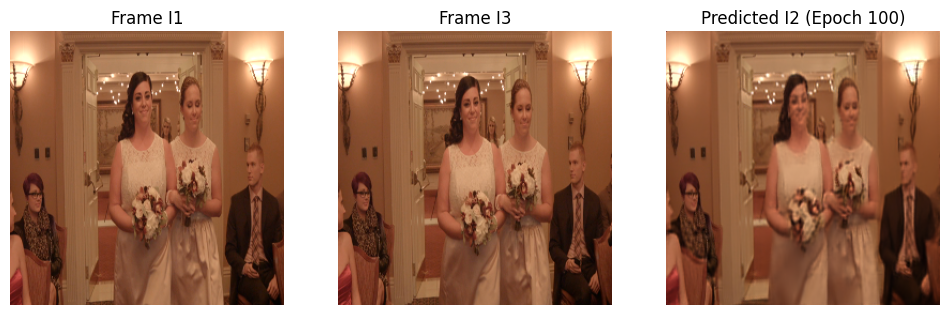

4116/4116 ━━━━━━━━━━━━━━━━━━━━ 1499s 362ms/step - loss: nan - psnr_metric: nan - ssim_loss: nan - val_loss: nan - val_psnr_metric: nan - val_ssim_loss: nan - learning_rate: 1.0000e-06
Epoch 101/150
4116/4116 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: nan - psnr_metric: nan - ssim_loss: nanINFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).

Epoch 101: saving model to /kaggle/working/vfi_epoch_101.keras

Epoch 101: val_ssim_loss did not improve from inf
4116/4116 ━━━━━━━━━━━━━━━━━━━━ 1430s 347ms/step - loss: nan - psnr_metric: nan - ssim_loss: nan - val_loss: nan - val_psnr_metric: nan - val_ssim_loss: nan - learning_rate: 1.0000e-06
Epoch 102/150
4116/4116 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: nan - psnr_metric: nan - ssim_loss: nanINFO:tensorflow:Reduce to

In [ ]:
from tensorflow.keras.models import load_model


if __name__ == '__main__':
    # --- DATASET CREATION ---
    train_dataset = create_tf_dataset(train_triplets, batch_size=BATCH_SIZE)
    test_dataset  = create_tf_dataset(test_triplets, batch_size=BATCH_SIZE)
    sample_batch = next(iter(test_dataset.take(1)))

    # --- STRATEGY SETUP ---
    print("Initializing MirroredStrategy for dual GPU training...")
    strategy = tf.distribute.MirroredStrategy()
    print(f'Number of devices: {strategy.num_replicas_in_sync}')

    # --- CALLBACKS ---
    from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

    callbacks_list = [
        ModelCheckpoint(
            filepath='/kaggle/working/vfi_epoch_{epoch:02d}.keras',
            save_best_only=False,
            verbose=1
        ),
        ModelCheckpoint(
            filepath='/kaggle/working/vfi_best_model.keras',
            monitor='val_ssim_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_ssim_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        ImageDisplayCallback(
            sample_batch,
            every_n_epochs=5
        )
    ]

    # --- CUSTOM OBJECTS ---
    with strategy.scope():
        model = tf.keras.models.load_model(
            latest_path,
            custom_objects=custom_objs
        )



    # --- TRAINING (RESUME OR START FRESH) ---
    history = resume_latest_checkpoint(
        strategy=strategy,
        callbacks_list=callbacks_list,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        total_epochs=150,          # your target total epochs
        custom_objects=custom_objs,
        checkpoint_dir="/kaggle/working"
    )